In [12]:
!pip install mysql.connector
!pip install matplotlib
!pip install s

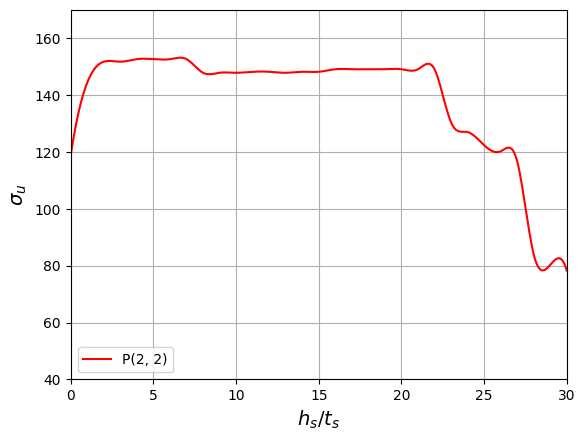

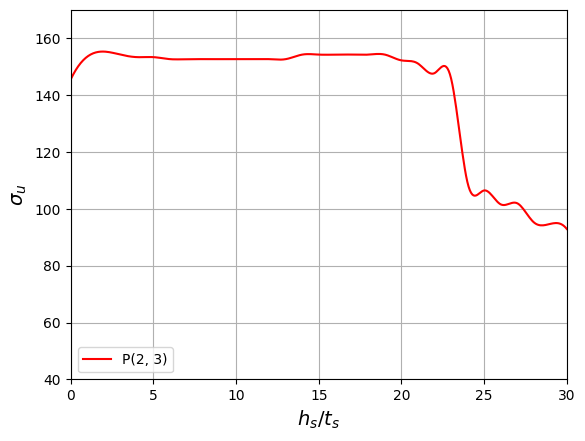

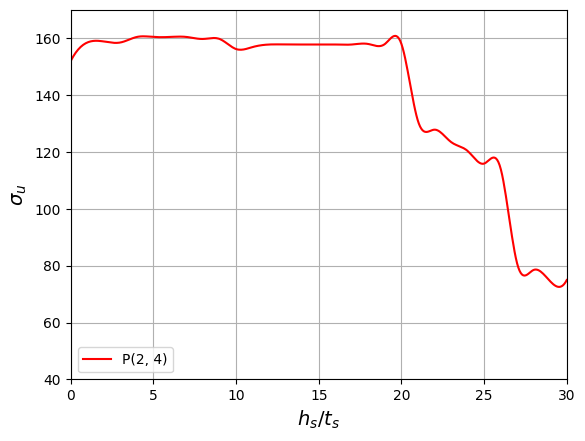

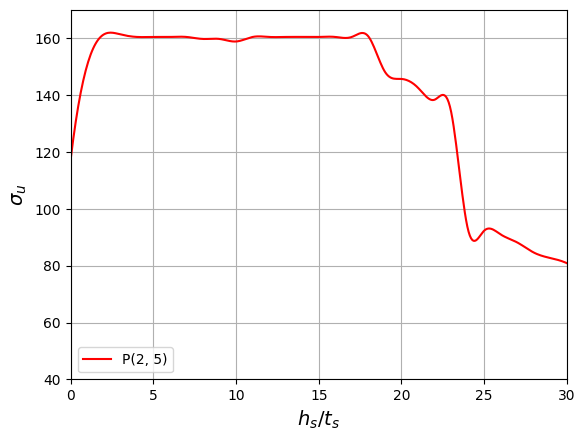

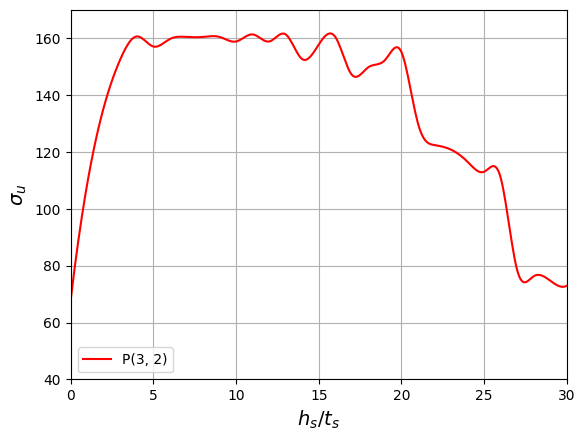

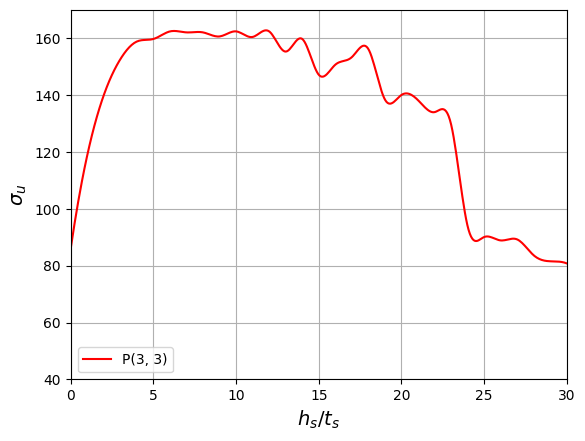

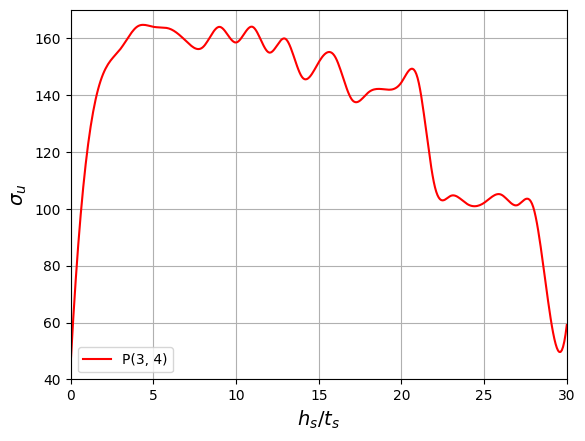

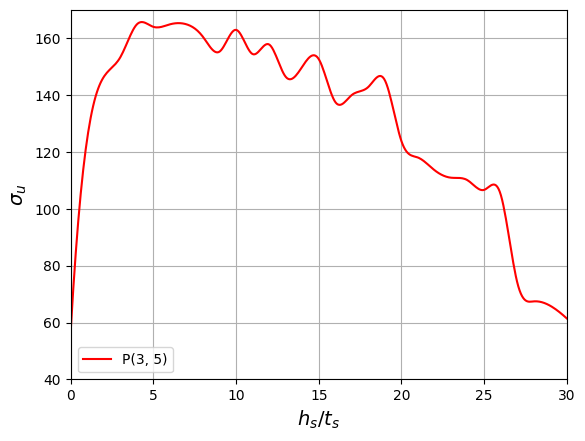

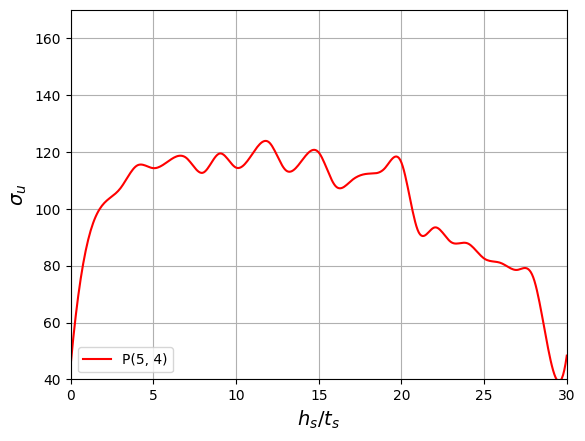

In [23]:
import mysql.connector
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

# 1. Conectar ao banco de dados MySQL
con = mysql.connector.connect(
    host="localhost",        
    user="constructal_automate",     
    password="constructal_design_2024",    
    database="constructal_automate_results"
)

cur = con.cursor()

query = f'''
SELECT sp.k, epb.sigma_u FROM constructal_automate_results.cbeb_elastoplasticbuckling as epb
INNER JOIN constructal_automate_results.cbeb_stiffenedplateanalysis as spa on epb.stiffened_plate_analysis_id=spa.id
INNER JOIN constructal_automate_results.csg_stiffenedplate as sp on spa.stiffened_plate_id=sp.id
WHERE sp.phi=0.3 AND sp.N_ls = {N_ls} AND sp.N_ts = {N_ts};
'''
cur.execute(query)
dados = cur.fetchall()

min_k = 0
max_k = 30
min_sigma_u = 40
max_sigma_u = 170

# Loop sobre os valores de N_ls e N_ts
for N_ls in range(2, 6):
    for N_ts in range(2, 6):
        # Executar a consulta SQL com os valores variáveis de N_ls e N_ts
        query = f'''
        SELECT sp.k, epb.sigma_u FROM constructal_automate_results.cbeb_elastoplasticbuckling as epb
        INNER JOIN constructal_automate_results.cbeb_stiffenedplateanalysis as spa on epb.stiffened_plate_analysis_id=spa.id
        INNER JOIN constructal_automate_results.csg_stiffenedplate as sp on spa.stiffened_plate_id=sp.id
        WHERE sp.phi=0.3 AND sp.N_ls = {N_ls} AND sp.N_ts = {N_ts};
        '''
        cur.execute(query)
        dados = cur.fetchall()

        if dados:
            k_data = [row[0] for row in dados]
            sigma_u_data = [row[1] for row in dados]

            k_data_smoothed = np.linspace(min_k, max_k, 400)
            spl = make_interp_spline(k_data, sigma_u_data, k=3)
            sigma_u_smoothed = spl(k_data_smoothed)
            
            # Criar o gráfico
            fig, ax = plt.subplots()

            # ax.plot(k_data, sigma_u_data, label=f'P({N_ls}, {N_ts})', color='red')
            # ax.plot(k_data_smoothed, sigma_u_smoothed, label=f'P({N_ls}, {N_ts})', color='red', marker='o')
            ax.plot(k_data_smoothed, sigma_u_smoothed, label=f'P({N_ls}, {N_ts})', color='red')

            # Configurar rótulos dos eixos e legenda
            ax.set_xlabel(r'$h_{s}/t_{s}$', fontsize=14)
            ax.set_ylabel(r'$\sigma_{u}$', fontsize=14)
            ax.legend(loc='lower left')

            # Adicionar a malha ao gráfico
            ax.grid(True)

            # Definir os limites dos eixos, se necessário
            ax.set_xlim([min_k, max_k])  # Limites do eixo X
            ax.set_ylim([min_sigma_u, max_sigma_u])  # Limites do eixo Y

            # Salvar o gráfico com o timestamp e valores de N_ls e N_ts no nome do arquivo
            plt.savefig(f'graficos_suavizados/verificacao_Nls{N_ls}_Nts{N_ts}.png')

            # Exibir o gráfico
            plt.show()

# Fechar a conexão com o banco de dados
con.close()